In [54]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
from tqdm import tqdm_notebook
import datetime
import time
import random
from joblib import Parallel, delayed


import lightgbm as lgb
from tensorflow import keras
#from gplearn.genetic import SymbolicRegressor
from catboost import Pool, CatBoostRegressor

#import numpy as np 
#import pandas as pd
from tqdm import tqdm
# Define model
from keras.models import Sequential
from keras.layers import Dense, CuDNNGRU, Dropout, TimeDistributed, LSTM, CuDNNLSTM
from keras.optimizers import adam, RMSprop
from keras.callbacks import ModelCheckpoint
# Fix seeds
from numpy.random import seed
#seed(639)
from tensorflow import set_random_seed
#set_random_seed(5944)

from numpy.random import seed
seed(639)
from tensorflow import set_random_seed
set_random_seed(5944)

import lightgbm as lgb
import xgboost as xgb
import time
import datetime

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.feature_selection import RFECV, SelectFromModel

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import NuSVR, SVR
from sklearn.kernel_ridge import KernelRidge
#from sklearn.ensemble import AdaBoostRegressor
#from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

from itertools import product

from tsfresh.feature_extraction import feature_calculators
from joblib import Parallel, delayed

import tensorflow as tf
import importlib

In [55]:
#importlib.reload(tf)

In [56]:
tf.__version__

'1.10.0'

In [57]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [58]:
i = 0

In [59]:
# Create a training file with simple derived features

def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    
    sta = np.cumsum(x ** 2)

    # Convert to float
    sta = np.require(sta, dtype=np.float)

    # Copy for LTA
    lta = sta.copy()

    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta

    # Pad zeros
    sta[:length_lta - 1] = 0

    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny

    return sta / lta

def calc_change_rate(x):
    change = (np.diff(x) / x[:-1]).values
    change = change[np.nonzero(change)[0]]
    change = change[~np.isnan(change)]
    change = change[change != -np.inf]
    change = change[change != np.inf]
    return np.mean(change)

In [60]:
def get_extremal_accelerations(df, sort_field_name='acoustic_data', num_of_extremals=12):
    sorted_df = df.sort_values(sort_field_name)
    extremal_accelerations = []
    for i in range(num_of_extremals):
        idx_min = sorted_df.index[i]
        idx_max = sorted_df.index[-i - 1]
        min_v = df.iloc[idx_min][sort_field_name]
        max_v = df.iloc[idx_max][sort_field_name]
        extremal_accelerations.append((
            (max_v - min_v) / (idx_max - idx_min)
        ))
    return extremal_accelerations

In [61]:
def get_extremal_accelerations(series, num_of_extremals=12):
    sorted_series = series.sort_values()
    extremal_accelerations = []
    for i in range(num_of_extremals):
        idx_min = sorted_series.index[i]
        idx_max = sorted_series.index[-i - 1]
        min_v = series.iloc[idx_min]
        max_v = series.iloc[idx_max]
        extremal_accelerations.append((
            (max_v - min_v) / (idx_max - idx_min)
        ))
    return extremal_accelerations

In [62]:
def get_extremals(series, num_of_extremals=6):

    sorted_series = series.sort_values()
    extremals_indexes = set()
    extremals = []
    
    i = 0
    min_idx_idx = 0
    max_idx_idx = 0
    extremals_coutner = 0
    while (extremals_coutner < num_of_extremals):

        idx_min = sorted_series.index[min_idx_idx]
        idx_min_not_proceed = not idx_min in extremals_indexes

        idx_max = sorted_series.index[-max_idx_idx - 1]
        idx_max_not_proceed = not idx_max in extremals_indexes

        if idx_min_not_proceed and idx_max_not_proceed:
            if idx_max < idx_min:               
                idx_min, idx_max = idx_max, idx_min
            extremals_indexes = extremals_indexes.union(set(range(idx_min, idx_max + 1)))
            extremals.append(series.iloc[idx_min:idx_max])
            min_idx_idx += 1
            max_idx_idx += 1
            extremals_coutner += 1
        else:
            if not idx_min_not_proceed:
                min_idx_idx += 1
            if not idx_max_not_proceed:
                max_idx_idx += 1

    return extremals, series.loc[set(series.index).difference(extremals_indexes)]

In [63]:
def get_extremals(series, num_of_extremals=12):
    sorted_series = series.sort_values()
    extremals_indexes = set()
    extremals = []    
    for i in range(num_of_extremals):
        idx_min = sorted_series.index[i]
        idx_max = sorted_series.index[-i - 1]
        if idx_max < idx_min:               
            idx_min, idx_max = idx_max, idx_min
        extremals_indexes = extremals_indexes.union(set(range(idx_min, idx_max + 1)))
        extremals.append(series.iloc[idx_min:idx_max])
        
    return extremals, series.loc[set(series.index).difference(extremals_indexes)]    
    

In [80]:
class FeatureGenerator(object):
    def __init__(self, dtype, n_jobs=1, chunk_size=None):
        self.chunk_size = chunk_size
        self.dtype = dtype
        self.filename = None
        self.n_jobs = n_jobs
        self.test_files = []
        if self.dtype == 'train':
            self.filename = '../input/train/train.csv'
            self.total_data = int(629145481 / self.chunk_size)
            #print("Feature Generator __init__, self.total_data:", self.total_data)
        else:
            submission = pd.read_csv('../input/sample_submission.csv')
            for seg_id in submission.seg_id.values:
                self.test_files.append((seg_id, '../input/test/' + seg_id + '.csv'))
            #print("Feature Generator __init__, int(len(submission)):", int(len(submission)))
            self.total_data = int(len(submission))

    def read_chunks(self):
        if self.dtype == 'train':
            iter_df = pd.read_csv(self.filename, iterator=True, chunksize=self.chunk_size,
                                  dtype={'acoustic_data': np.float64, 'time_to_failure': np.float64})
            for counter, df in enumerate(iter_df):
                x = df.acoustic_data.values
                y = df.time_to_failure.values[-1]
                seg_id = 'train_' + str(counter)
                del df
                yield seg_id, x, y
        else:
            for seg_id, f in self.test_files:
                df = pd.read_csv(f, dtype={'acoustic_data': np.float64})
                x = df.acoustic_data.values[-self.chunk_size:]
                del df
                yield seg_id, x, -999
    
    def get_features(self, x, y, seg_id):
        """
        Gets three groups of features: from original data and from reald and imaginary parts of FFT.
        """
        
        x = pd.Series(x)
        
        '''
        zc = np.fft.fft(x)
        realFFT = pd.Series(np.real(zc))
        imagFFT = pd.Series(np.imag(zc))
        '''
        
        
        main_dict = self.features(x, y, seg_id)
        
        '''
        r_dict = self.features(realFFT, y, seg_id)
        i_dict = self.features(imagFFT, y, seg_id)
        
        for k, v in r_dict.items():
            if k not in ['target', 'seg_id']:
                main_dict[f'fftr_{k}'] = v
                
        for k, v in i_dict.items():
            if k not in ['target', 'seg_id']:
                main_dict[f'ffti_{k}'] = v
        '''
        return main_dict
        
    
    def features(self, x, y, seg_id):
        feature_dict = dict()
        feature_dict['target'] = y
        feature_dict['seg_id'] = seg_id

        # create features here

        # lists with parameters to iterate over them
        #percentiles = [1, 5, 10, 20, 25, 30, 40, 50, 60, 70, 75, 80, 90, 95, 99]
        percentiles = [10, 20]
        hann_windows = [50, 150, 1500, 15000]
        spans = [300, 3000, 30000, 50000]
        windows = [10, 50, 100, 500, 1000, 10000]
        borders = list(range(-4000, 4001, 1000))
        #peaks = [10, 20, 50, 100]
        peaks = [10]
        coefs = [1, 5, 10, 50, 100]
        lags = [10, 100, 1000, 10000]
        #autocorr_lags = [5, 10, 50, 100, 500, 1000, 5000, 10000]
        autocorr_lags = [5]
        
        # basic stats
        feature_dict['mean'] = x.mean()
        feature_dict['std'] = x.std()
        feature_dict['max'] = x.max()
        feature_dict['min'] = x.min()
        
        extremals, not_extremals = get_extremals(x, num_of_extremals=5)
        
        
        for i, extremal in enumerate(extremals):
            feature_dict[f'extr_accel_{i}'] = np.abs((extremal.max() - extremal.min()) / len(extremal))
            feature_dict[f'extr_mean_{i}'] = extremal.mean()
            feature_dict[f'extr_std_{i}'] = extremal.std()
            
            '''
            print()
            extr_fft = np.fft.fft(extremal)
            print("len(extr_fft):", len(extr_fft))
            extr_fft = extr_fft[:3]
            print("len(extr_fft[:3]):", len(extr_fft))
            print("extr_fft.shape", extr_fft.shape)
            print("extr_fft:\n", extr_fft)
            for j, extr in enumerate(extr_fft):
                feature_dict[f'extr_fft_re_{i}_{j}'] = np.real(extr)
                print("extr_fft_re_{}_{}:".format(i, j), feature_dict[f'extr_fft_re_{i}_{j}'])
                feature_dict[f'extr_fft_im_{i}_{j}'] = np.imag(extr)
                print("extr_fft_im_{}_{}:".format(i, j), feature_dict[f'extr_fft_im_{i}_{j}'])
            print() 
            #for k, extr in enumerate(np.imag(extr_fft)):
            #    feature_dict[f'extr_fft_im_{i}_{k}'] = extr
            #    print("extr_fft_im_{}_{}:\n".format(i, k), feature_dict[f'extr_fft_im_{i}_{k}'])
                
            #print()
        '''
        min_points_num = 6
        #print("len(x):", len(x))
        filtered_x = x[np.abs(x) > 150]
        for threshold in range(130, 50, 20):
            if len(filtered_x) < min_points_num:
                filtered_x = x[np.abc(x) > threshold]
                break

        if len(filtered_x) < min_points_num:

        #print("len(filtered_x):", len(filtered_x))
        fft_filtered_x = np.fft.fft(filtered_x)[:min_points_num]
        for i, item in enumerate(fft_filtered_x):
            feature_dict[f'v_fft_re_{i}'] = np.real(item)
            feature_dict[f'v_fft_im_{i}'] = np.imag(item)
            
        for i, item in enumerate(x.value_counts().iloc[:5].items()):
            feature_dict[f'rel_freq_{i}'] = item[0] / item[1]

        #feature_dict[f'fft'] = acoustic_data[np.abs(acoustic_data) > 150]
        '''
        
        feature_dict[f'not_extr_mean'] = not_extremals.mean()
        feature_dict[f'not_extr_std'] = not_extremals.std()
        feature_dict[f'not_extr_min'] = not_extremals.min()
        feature_dict[f'not_extr_max'] = not_extremals.max()
        '''
            
        '''
        # basic stats on absolute values
        feature_dict['mean_change_abs'] = np.mean(np.diff(x))
        feature_dict['abs_max'] = np.abs(x).max()
        feature_dict['abs_mean'] = np.abs(x).mean()
        feature_dict['abs_std'] = np.abs(x).std()
        '''
        

        # geometric and harminic means
        '''
        feature_dict['hmean'] = stats.hmean(np.abs(x[np.nonzero(x)[0]]))
        feature_dict['gmean'] = stats.gmean(np.abs(x[np.nonzero(x)[0]])) 

        # k-statistic and moments
        for i in range(1, 5):
            feature_dict[f'kstat_{i}'] = stats.kstat(x, i)
            feature_dict[f'moment_{i}'] = stats.moment(x, i)

        for i in [1, 2]:
            feature_dict[f'kstatvar_{i}'] = stats.kstatvar(x, i)
        '''

        '''
        # aggregations on various slices of data
        for agg_type, slice_length, direction in product(['std', 'min', 'max', 'mean'], [1000, 10000, 50000], ['first', 'last']):
            if direction == 'first':
                feature_dict[f'{agg_type}_{direction}_{slice_length}'] = x[:slice_length].agg(agg_type)
            elif direction == 'last':
                feature_dict[f'{agg_type}_{direction}_{slice_length}'] = x[-slice_length:].agg(agg_type)
        '''
        

        '''
        feature_dict['max_to_min'] = x.max() / np.abs(x.min())
        feature_dict['max_to_min_diff'] = x.max() - np.abs(x.min())
        feature_dict['count_big'] = len(x[np.abs(x) > 500])
        feature_dict['sum'] = x.sum()

        feature_dict['mean_change_rate'] = calc_change_rate(x)
        # calc_change_rate on slices of data
        for slice_length, direction in product([1000, 10000, 50000], ['first', 'last']):
            if direction == 'first':
                feature_dict[f'mean_change_rate_{direction}_{slice_length}'] = calc_change_rate(x[:slice_length])
            elif direction == 'last':
                feature_dict[f'mean_change_rate_{direction}_{slice_length}'] = calc_change_rate(x[-slice_length:])
        '''
        
        '''
        # percentiles on original and absolute values
        for p in percentiles:
            feature_dict[f'percentile_{p}'] = np.percentile(x, p)
            feature_dict[f'abs_percentile_{p}'] = np.percentile(np.abs(x), p)
        '''
        
        '''
        feature_dict['trend'] = add_trend_feature(x)
        feature_dict['abs_trend'] = add_trend_feature(x, abs_values=True)
        '''

        #feature_dict['mad'] = x.mad()
        feature_dict['kurt'] = x.kurtosis()
        feature_dict['skew'] = x.skew()
        #feature_dict['med'] = x.median()

        '''
        feature_dict['Hilbert_mean'] = np.abs(hilbert(x)).mean()

        for hw in hann_windows:
            feature_dict[f'Hann_window_mean_{hw}'] = (convolve(x, hann(hw), mode='same') / sum(hann(hw))).mean()

        feature_dict['classic_sta_lta1_mean'] = classic_sta_lta(x, 500, 10000).mean()
        feature_dict['classic_sta_lta2_mean'] = classic_sta_lta(x, 5000, 100000).mean()
        feature_dict['classic_sta_lta3_mean'] = classic_sta_lta(x, 3333, 6666).mean()
        feature_dict['classic_sta_lta4_mean'] = classic_sta_lta(x, 10000, 25000).mean()
        feature_dict['classic_sta_lta5_mean'] = classic_sta_lta(x, 50, 1000).mean()
        feature_dict['classic_sta_lta6_mean'] = classic_sta_lta(x, 100, 5000).mean()
        feature_dict['classic_sta_lta7_mean'] = classic_sta_lta(x, 333, 666).mean()
        feature_dict['classic_sta_lta8_mean'] = classic_sta_lta(x, 4000, 10000).mean()
        '''
        
        '''
        # exponential rolling statistics
        ewma = pd.Series.ewm
        for s in spans:
            feature_dict[f'exp_Moving_average_{s}_mean'] = (ewma(x, span=s).mean(skipna=True)).mean(skipna=True)
            feature_dict[f'exp_Moving_average_{s}_std'] = (ewma(x, span=s).mean(skipna=True)).std(skipna=True)
            feature_dict[f'exp_Moving_std_{s}_mean'] = (ewma(x, span=s).std(skipna=True)).mean(skipna=True)
            feature_dict[f'exp_Moving_std_{s}_std'] = (ewma(x, span=s).std(skipna=True)).std(skipna=True)

        feature_dict['iqr'] = np.subtract(*np.percentile(x, [75, 25]))
        feature_dict['iqr1'] = np.subtract(*np.percentile(x, [95, 5]))
        feature_dict['ave10'] = stats.trim_mean(x, 0.1)
        '''
        
        '''
        for slice_length, threshold in product([50000, 100000, 150000],
                                                     [5, 10, 20, 50, 100]):
            feature_dict[f'count_big_{slice_length}_threshold_{threshold}'] = (np.abs(x[-slice_length:]) > threshold).sum()
            feature_dict[f'count_big_{slice_length}_less_threshold_{threshold}'] = (np.abs(x[-slice_length:]) < threshold).sum()

        # tfresh features take too long to calculate, so I comment them for now

#         feature_dict['abs_energy'] = feature_calculators.abs_energy(x)
#         feature_dict['abs_sum_of_changes'] = feature_calculators.absolute_sum_of_changes(x)
#         feature_dict['count_above_mean'] = feature_calculators.count_above_mean(x)
#         feature_dict['count_below_mean'] = feature_calculators.count_below_mean(x)
#         feature_dict['mean_abs_change'] = feature_calculators.mean_abs_change(x)
#         feature_dict['mean_change'] = feature_calculators.mean_change(x)
#         feature_dict['var_larger_than_std_dev'] = feature_calculators.variance_larger_than_standard_deviation(x)
        feature_dict['range_minf_m4000'] = feature_calculators.range_count(x, -np.inf, -4000)
        feature_dict['range_p4000_pinf'] = feature_calculators.range_count(x, 4000, np.inf)
        '''
        
        '''
        for i, j in zip(borders, borders[1:]):
            feature_dict[f'range_{i}_{j}'] = feature_calculators.range_count(x, i, j)
        '''

#         feature_dict['ratio_unique_values'] = feature_calculators.ratio_value_number_to_time_series_length(x)
#         feature_dict['first_loc_min'] = feature_calculators.first_location_of_minimum(x)
#         feature_dict['first_loc_max'] = feature_calculators.first_location_of_maximum(x)
#         feature_dict['last_loc_min'] = feature_calculators.last_location_of_minimum(x)
#         feature_dict['last_loc_max'] = feature_calculators.last_location_of_maximum(x)

#         for lag in lags:
#             feature_dict[f'time_rev_asym_stat_{lag}'] = feature_calculators.time_reversal_asymmetry_statistic(x, lag)
        ## for autocorr_lag in autocorr_lags:
        ##    feature_dict[f'autocorrelation_{autocorr_lag}'] = feature_calculators.autocorrelation(x, autocorr_lag)
        ##    #feature_dict[f'c3_{autocorr_lag}'] = feature_calculators.c3(x, autocorr_lag)

#         for coeff, attr in product([1, 2, 3, 4, 5], ['real', 'imag', 'angle']):
#             feature_dict[f'fft_{coeff}_{attr}'] = list(feature_calculators.fft_coefficient(x, [{'coeff': coeff, 'attr': attr}]))[0][1]

#         feature_dict['long_strk_above_mean'] = feature_calculators.longest_strike_above_mean(x)
#         feature_dict['long_strk_below_mean'] = feature_calculators.longest_strike_below_mean(x)
#         feature_dict['cid_ce_0'] = feature_calculators.cid_ce(x, 0)
#         feature_dict['cid_ce_1'] = feature_calculators.cid_ce(x, 1)
        
    
        '''
        for p in percentiles:
            feature_dict[f'binned_entropy_{p}'] = feature_calculators.binned_entropy(x, p)

        feature_dict['num_crossing_0'] = feature_calculators.number_crossing_m(x, 0)
        '''
        
        ## for peak in peaks:
        ##    feature_dict[f'num_peaks_{peak}'] = feature_calculators.number_peaks(x, peak)
        
        '''
        for c in coefs:
            feature_dict[f'spkt_welch_density_{c}'] = list(feature_calculators.spkt_welch_density(x, [{'coeff': c}]))[0][1]
            feature_dict[f'time_rev_asym_stat_{c}'] = feature_calculators.time_reversal_asymmetry_statistic(x, c)  
        '''
        
        # statistics on rolling windows of various sizes
        for w in windows:
            break
            #pass
            ## x_roll_std = x.rolling(w).std().dropna().values
            ## x_roll_mean = x.rolling(w).mean().dropna().values
            
            
            #feature_dict[f'ave_roll_std_{w}'] = x_roll_std.mean()
            #feature_dict[f'std_roll_std_{w}'] = x_roll_std.std()
            #feature_dict[f'max_roll_std_{w}'] = x_roll_std.max()
            
            ## feature_dict[f'min_roll_std_{w}'] = x_roll_std.min()
            

            ## for p in percentiles:
            ##    feature_dict[f'percentile_roll_std_{p}_window_{w}'] = np.percentile(x_roll_std, p)
            
            '''
            feature_dict[f'av_change_abs_roll_std_{w}'] = np.mean(np.diff(x_roll_std))
            feature_dict[f'av_change_rate_roll_std_{w}'] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
            feature_dict[f'abs_max_roll_std_{w}'] = np.abs(x_roll_std).max()

            feature_dict[f'ave_roll_mean_{w}'] = x_roll_mean.mean()
            feature_dict[f'std_roll_mean_{w}'] = x_roll_mean.std()
            feature_dict[f'max_roll_mean_{w}'] = x_roll_mean.max()
            feature_dict[f'min_roll_mean_{w}'] = x_roll_mean.min()
            
            for p in percentiles:
                feature_dict[f'percentile_roll_mean_{p}_window_{w}'] = np.percentile(x_roll_mean, p)

            feature_dict[f'av_change_abs_roll_mean_{w}'] = np.mean(np.diff(x_roll_mean))
            feature_dict[f'av_change_rate_roll_mean_{w}'] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
            feature_dict[f'abs_max_roll_mean_{w}'] = np.abs(x_roll_mean).max()    
            '''

        return feature_dict

    def generate(self):
        feature_list = []
        res = Parallel(n_jobs=self.n_jobs,
                       backend='threading')(delayed(self.get_features)(x, y, s)
                                            for s, x, y in tqdm_notebook(self.read_chunks(), total=self.total_data))
        #print("FeatureGenerator, generate, type(res)", type(res))
        #print("FeatureGenerator, generate, len(res)", len(res))
        for r in res:
            feature_list.append(r)
        #print("FeatureGenerator, generate, len(feature_list)", len(feature_list))
        return pd.DataFrame(feature_list)

In [81]:
def select_columns(df, selection_list=[], condition=False):
    if condition:
        return [df.columns.get_loc(col) for col in df.columns if col in selection_list]
    else:
        return [df.columns.get_loc(col) for col in df.columns if col not in selection_list]

In [82]:
i += 1

In [83]:
training_fg = FeatureGenerator(dtype='train', n_jobs=20, chunk_size=30000)


training_data = training_fg.generate()

test_fg = FeatureGenerator(dtype='test', n_jobs=20, chunk_size=30000)
test_data = test_fg.generate()

X = training_data.drop(['target', 'seg_id'], axis=1)
X_test = test_data.drop(['target', 'seg_id'], axis=1)
test_segs = test_data.seg_id
y = training_data.target
train_y = y

len(x): 30000
len(filtered_x): 30000
len(x):len(x): 30000
 len(filtered_x):30000
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x):len(x):  30000
30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x):len(filtered_x): 30000 30000

len(x): 30000
len(filtered_x):len(x): 30000
 30000
len(filtered_x): 21
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x): 30000
 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x):len(filtered_x): 30000
 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x):len(x):  30000
30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x):len(filtered_x): 30000
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
l

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x): 30000
 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 24
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(

len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x): 30000
 30000
len(filtered_x): 30000len(filtered_x): 30000

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x): 30000
 30000
len(filtered_x): 30000
l

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000len(x):
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x):len(filtered_x): 30000
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000len(x): 30000

len(filtered_x): 30000
len(x): 30000
len(filtered_x): 45
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x):len(x): 30000
 30000
len(filtered_x): 30000
len(

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000len(x): 30000

len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
l

len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30
len(x): 30000
len(filtered_x): 30000
len(

len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): len(filtered_x):30000
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 55
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 721
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filte

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x): 30000
 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(filtered_x): 30000len(x): 30000

len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x): 30000
 30000
len(filter

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x): 30000 30000

len(filtered_x):len(filtered_x): 30000
 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
l

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): len(x): 30000
30000
len(filtered_x): len(x):len(filtered_x): 30000
 30000
30000len(filtered_x):
 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
l

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): len(filtered_x): 30000
30000
len(x): 30000
len(filtered_x):len(x): 30000
len(filtered_x): 30000
 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000len(x): 30000

len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
l

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x): 30000
 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000len(x): 30000

len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
l

len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x): 30000
 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x): 30000
len(filtered_x): 30000
 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 46
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(

len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 43
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): len(x): 30000
30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x):len(x): 30000
 30000
len(filtered_x): 63
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 94
len(x): 30000
len(filtered_x): 30000
len(x): 30

len(filtered_x): 33
len(x): 30000
len(filtered_x): 618
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 47
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 33
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x): 30000
 30000
len(filtered_x): 30000
len(filtered

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): len(x): 30000
30000len(filtered_x): 30000

len(filtered_x): 30000
len(x):len(x): 30000
 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): len(filtered_x):30000
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x):len(filtered_x): 30000
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
l

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): len(x): 30000
30000len(filtered_x): 30000

len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
l

len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): len(filtered_x): 30000
30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x):len(x): 30000
len(filtered_x): 30000
 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(x):len(filtered_x): 30000
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x)

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x):len(filtered_x): 42
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 23
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000len(x):
 30000
len(filtered_x): 30000len(filtered_x): 30000

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): len(filtered_x): 30000
30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30
len(x): 30000
len(filtered_x): 21
len(x): 30000
len(filtered_x): len(x): 30000
len(filtered_x): 20
30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x): 30000
 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): len(x): 3000030000

len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): len(x):30000 30000
len(filtered_x): 
30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 189
len(x): 3000

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x):len(filtered_x): 30000
 30000
len(filtered_x): 30000
len(x): 30000
len(x):len(filtered_x): 30000
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x):len(filtered_x): 30000
 30000
len(filtered_x): 30000
l

len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): len(x): 30000
30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x):len(filtered_x): 30000
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
l

len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): len(x): 30000
len(filtered_x):30000
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x):len(filtered_x):  30000
30000len(x):
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): len(x): 30000
30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
l

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): len(filtered_x): 30000
30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 74
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x):len(x): 30000
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x):len(filtered_x): 30000
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): len(x): 3000030000

len(filtered_x):len(x): 30000
len(filtered_x): 30000
 30000
len(x): 30000
len(filtered_x): 65
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 44
len(x): 30000
len(x): len(filtered_x): 30000
30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 23
len(x): 30000
len(filtered_x): 30000
len(x):len(x): 30000 30000

len(filtered_x):len(filtered_x): 30000 30000

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(x):len(filtered_x): 30000
 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 33
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 28
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): len(x): 30000
30000
len(filtered_x): len(x): 30000
30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 20
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 56
len(x): 30000
len(x): len(filtered_x): 30000
30000
len(x): 30000
len(filtered_x):len(filtered_x): 30000
 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x): 30000
 len(filtered_x):30000 len(x):
 30000
116
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 3

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): len(x): 30000
30000len(filtered_x): 30000

len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000len(x): 30000len(x): 30000
len(x):
len(filtered_x): 30000
 30000

len(x): 30000
len(filtered_x): 30000len(filtered_x): 30000

len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x): 30000
 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
l

len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): len(x): 30000
30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
l

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): len(x):30000 30000
len(filtered_x): 30000

len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filter

len(x): 30000
len(filtered_x): 61
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x):  30000
30000
len(filtered_x):len(filtered_x): 30000
 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): len(filtered_x): 30000
30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000len(x):len(x): 30000

len(filtered_x): 30000
 30000
len(filtered_x): 282
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x):len(filtered_x): 30000
 30000
len(filtered_x): 30000
len(x): len(x): 3000030000

len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(x):len(filtered_x): 30000
 30000
len(filtered_x): 30000
len(x): 30000
len(x):len(filtered_x): 20
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 1945
len(x): 30000
len(filtered_x): 2965
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): len(x):30000
 30000
len(x): 30000
len(filtered_x):l

len(x): 30000
len(filtered_x): len(x):30000
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x):len(x):  30000
30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x):len(x): 30000
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x): 30000
 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x):  30000
30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
l

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x):  30000
30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x): 30000
 len(filtered_x): 30000
30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): len(x): 3000030000

len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000len(x):
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
l

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x): 30000
 30000len(filtered_x): 30000

len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x):len(filtered_x): 30000
 30000
len(filtered_x): 30000
len(x): 30000len(x): 30000

len(filtered_x): 30000
len(filtered_x): 780
len(x): 30000
len(filtered_x): 30000
len(x):len(x): 30000
 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x):len(x): 30000
 30000
len(filtered_x):len(filtered_x):  30000
30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000len(filtered_

len(filtered_x): 30000
len(x): 30000
len(filtered_x): 74
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 67
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 25
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x):len(filtered_x): 30000
 30000
len(x): len(x): 30000
30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x): 30000 
30000
len(filtered_x): 30000len(filtered_x): 30000

len(x): 30000
len(filter

 len(filtered_x):30000
len(filtered_x): 30000
 30000
len(x): 30000len(x): 30000

len(filtered_x):len(x):len(filtered_x): 30000
 30000
 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): len(filtered_x): 30000
len(x):30000 30000

len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x):len(x): 30000
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filt

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): len(filtered_x): 30000
30000
len(x):len(filtered_x):  30000
len(filtered_x):30000
 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): len(x):30000 
30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
l

len(x): 30000
len(filtered_x): 30000
len(x): len(x):30000
len(filtered_x): 30000
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): len(x): 3000030000
len(filtered_x): 
30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x):  30000
30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): len(x):30000 30000

len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x):len(filtered_x): 30000
 42
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x): 30000
 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(

len(x): len(x): 30000
30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x):  30000
30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x):len(filtered_x): len(x): 30000
 30000
len(filtered_x): 30000
len(filtered_x): 30000
30000
l

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000len(x): 30000

len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x): 30000
 30000
len(filtered_x): len(filtered_x): 30000
30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
l

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x):len(filtered_x): 30000
 30000
len(filtered_x): 30000len(x):
 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x):len(filtered_x): 30000
 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 39
len(x): 30000
len(filtered_x):len(x): 30000
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000len(x):
 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x): 30000
 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 22
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(

len(x):len(x): 30000
 len(filtered_x): 30000
30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000len(filtered_x): 30000

len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 32
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x):  3000030000

len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x):len(filtered_x): 30000
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x):len(x): 30000
 len(x): 30000
30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000len(filtered_x): 30000

len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(

len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 48
len(x): 30000
len(x): len(filtered_x):30000 30000

len(filtered_x): 70
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): len(x):30000 30000

len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 55
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filter

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x):len(x): 30000
 30000
len(x): 30000
len(filtered_x): len(filtered_x):30000 30000

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): len(x):30000 30000

len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 24
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x):len(filtered_x): 30000
 30000
len(filtered_x):len(x): 30000
 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x):len(filtered_x): 30000
 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x):len(x): 30000 
30000
len(x):len(filtered_x): 30000
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(

len(x):len(x): 30000
 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x):len(filtered_x): 30000
 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): len(filtered_x): 3000030000

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x): 30000
 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): len(filtered_x):

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x): 30000
len(filtered_x): 30000len(x): 30000

len(filtered_x): 29
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x):len(filtered_x): 30000
len(x): 30000
 30000
len(x):len(filtered_x): 30000
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000len(x): 30000

len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): len(filtered_x): 30000
30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): len(x):len(x): 30000
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000len(x): 30000

len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x): 30000
 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
l

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): len(x): 30000
30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
l

len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x):  30000
len(x): 30000
30000
len(filtered_x): 30000
len(filtered_x): len(filtered_x): 30000
30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
l

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x):len(filtered_x): 

len(x): 30000
len(x):len(filtered_x): 30000
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 146
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x): 30000
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 26
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x): 30000
len(filtered_x): 30000
 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x):len(filtered_x): 30000
 30000
len(filtered_x): 30000
len(x)

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000len(x): 
len(filtered_x): 30000
30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x):len(filtered_x): 30000
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x): 30000
len(filtered_x): 30000
 len(filtered_x):30000 30000

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): len(filtered_x): 30000
30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
l

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x):len(filtered_x): 30000
len(x): 30000
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): len(x):

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x): 30000
 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
l

len(x): 30000len(x):
len(filtered_x): 30000 30000
len(filtered_x): 30000

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): len(x): 30000
30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): len(x): 3000030000

len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filter

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000len(x): 30000

len(filtered_x): 30000
len(x): len(x): 30000
30000
len(filtered_x):len(filtered_x): 30000
 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): len(filtered_x): 30000
30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x): 30000
len(filtered_x): 30000
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
l

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 93
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x): 30000
len(filtered_x):  30000
30000
len(filtered_x): 58
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):

len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): len(filtered_x):30000 110

len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len

len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 23
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 77
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): len(x): 30000
30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(fil

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x):len(filtered_x): 30000
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): len(x): 30000
30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
l

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(filtered_x): len(x): 30000
30000
 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): len(x): 30000
30000len(filtered_x):
 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
l

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x):len(x):  3000030000

len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
l

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 50
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000len(x): 30000

len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x):len(filtered_x): 30000
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x): 30000
len(filtered_x): 30000
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000len(x):
 len(filtered_x): 30000
30000len(x):
len(filtered_x): 30000
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 22
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): len(x): 30000
30000
len(filtered_x): 30000
len(x):len(x): 30000
 30000
len(filtered_x):len(filtered_x): 30000
 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 75
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 68
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 85
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): len(filtered_x): 3000030000

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x):len(filtered_x): 20
 30000
len(x): 30000

len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x): 30000 30000

len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): len(x): 30000
len(filtered_x): 30000
30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
l

len(x): 30000
len(x): 30000
len(filtered_x):len(filtered_x): 30000
 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x):len(x): len(filtered_x): 30000
 30000
30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
l

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): len(filtered_x): 30000
len(x):30000
 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): len(x): 30000
30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
l

len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 50
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(

len(filtered_x): 30000
len(x): 30000
len(filtered_x): 31
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): len(x):30000
len(filtered_x): 30000
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): len(x): 30000
30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000len(x):
 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000len(x):
len(filtered_x): 30000
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x):len(filtered_x): 30000
 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(x):len(filtered_x): 30000
len(filtered_x): 30000
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
l

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x):  30000
30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x): 30000
 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
l

len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 37
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x):len(filtered_x): 30000 30000

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): len(x): 30000
30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x): 30000
 30000len(filtered_x): 30000

len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x): 30000
len(x):  len(filtered_x): 30000
30000
len(filtered_x):30000 30000

len(filtered_x): 30000
len(x): 30000
len(

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x):len(filtered_x): 30000
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
l

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): len(filtered_x): 30000
30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x):len(x): 30000
 len(filtered_x): 30000
30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 47
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x):len(x): 30000
 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x):len(x): 30000
 30000
len(filtered_

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): len(x): 30000
30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(x):len(filtered_x): 30000
len(x): 30000
 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x):len(filtered_x): 30000
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): len(x):

len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): len(x):30000
 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x):  30000
len(filtered_x): 30000
30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
l

len(x): 30000
len(filtered_x): 30000
len(x): len(x): 30000
30000
len(filtered_x):len(filtered_x):  len(x):30000 30000
30000

len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): len(x): 30000
30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000len(x): 30000

len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000len(x):
 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(x):len(filtered_x): 30000
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): len(x): 30000
30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
l

len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): len(x): 30000
len(filtered_x): 30000
30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x):len(filtered_x): 30000
len(filtered_x): 30000
 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x):  30000
len(filtered_x): 30000
30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): len(x): 3000030000

len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
l

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000len(x):
 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
l

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 42
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 43
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 964
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x):len(filtered_x): 30000
 30000
len(x):len(filtered_x): 39
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): len(x):30000 
len(filtered_x): 30000
30000
len(filtered_x): 30000
len(x): 3000

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x):len(x):  30000
30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): len(x):30000
len(x): 30000
 30000
len(filtered_x): 37
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 90
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x):len(x): 30000
 30000
len(filtered_x): 30000
len(x):

len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): len(x): 30000
30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): len(x): 30000
30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
l

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 88
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 570
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 766
len(x): 30000
len(filtered_x): 2491
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 3

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x):len(filtered_x): 30000
 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x):len(x): 30000
len(filtered_x): 30000
 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x):len(x): 30000
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x):  30000
30000
len(filtered_x):len(filtered_x): 30000
 30000
len(x): 30000
len(filtered_x): 30000
l

len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000len(x): 30000

len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): len(x): 30000
len(filtered_x): 30000
30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x): 30000
 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000len(x): 
30000len(x): 
30000
len(filtered_x): 30000
l

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): len(x): 3000030000

len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x):len(filtered_x): 30000
 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x):len(x): 30000
 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 71
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x):len(filtered_x): 30000
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 39
len(x): 30000
len(filtered_x): 55
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x):len(x): 30000 

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x): 30000
 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
l

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):len(x): 30000
 30000
len(x): 30000
len(filtered_x):len(filtered_x): 30000
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): len(x): 30000
len(filtered_x): 30000
30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): len(filtered_x): 30000
30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
l

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
l

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 62
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 41
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(

len(x): 30000
len(filtered_x): 34
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 96
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 123
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x)

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
l

len(x): 30000
len(filtered_x): 1148
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
le

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 29
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 28
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x):

len(x): 30000
len(filtered_x): 205
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x): 30000
len(filtered_x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(x):len(filtered_x): 30000
 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
l

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 91
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(

len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 25
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(x): 30000
len(filtered_x): 30000
len(

In [84]:
X.head()

,extr_accel_0,extr_accel_1,extr_accel_2,extr_accel_3,extr_accel_4,extr_mean_0,extr_mean_1,extr_mean_2,extr_mean_3,extr_mean_4,...,v_fft_im_0,v_fft_im_1,v_fft_im_2,v_fft_im_3,v_fft_im_4,v_fft_re_0,v_fft_re_1,v_fft_re_2,v_fft_re_3,v_fft_re_4
0,21.777778,18.363636,24.428571,18.222222,1.887850,13.555556,11.454545,15.714286,-22.111111,5.429907,...,0.0,-1622.527147,-561.422514,304.065221,-1977.392675,150351.0,1225.730939,-530.481270,-1060.173040,1196.064201
1,8.750000,7.500000,0.004669,0.007467,0.007361,8.625000,7.200000,4.917457,4.881322,4.889489,...,0.0,-1359.143098,-546.991370,-1234.171350,-814.669791,145401.0,592.156306,599.695132,828.138234,862.173978
2,11.555556,0.004831,0.004381,0.004831,0.004917,2.777778,5.189255,5.190115,5.184966,5.188974,...,0.0,-37.041983,-1463.691504,-228.928989,25.121331,153963.0,-1309.822126,-1146.789123,-1605.145368,-542.283274
3,6.800000,7.875000,2.880000,2.769231,2.666667,9.800000,10.750000,2.920000,6.653846,3.148148,...,0.0,-2739.059192,-1781.741144,-254.503859,-2063.392319,147660.0,1846.501449,90.501396,-278.429639,-114.140034
4,0.297872,0.070764,0.002079,0.465909,0.573529,5.120567,4.750466,4.401866,5.602273,4.308824,...,0.0,45.405687,1990.014630,1443.411576,630.763048,135242.0,3308.135813,652.787426,-239.102702,960.019851


In [85]:
X.shape

(20972, 36)

In [86]:
means_dict = {}
for col in X.columns:
    if X[col].isnull().any():
        print(col)
        mean_value = X.loc[X[col] != -np.inf, col].mean()
        X.loc[X[col] == -np.inf, col] = mean_value
        X[col] = X[col].fillna(mean_value)
        means_dict[col] = mean_value

In [87]:
for col in X_test.columns:
    if X_test[col].isnull().any():
        X_test.loc[X_test[col] == -np.inf, col] = means_dict[col]
        X_test[col] = X_test[col].fillna(means_dict[col])

In [88]:
X_test_col = X_test.columns

In [89]:
scaler = StandardScaler()
train_columns = X.columns
#scaler.fit_transform(X[train_columns])
X[train_columns] = scaler.fit_transform(X[train_columns])
X_test[train_columns] = scaler.transform(X_test[train_columns])
test_X = X_test

#print(type(X))
#print(type(X_test))
#print(type(test_X))

In [90]:
X.head()

,extr_accel_0,extr_accel_1,extr_accel_2,extr_accel_3,extr_accel_4,extr_mean_0,extr_mean_1,extr_mean_2,extr_mean_3,extr_mean_4,...,v_fft_im_0,v_fft_im_1,v_fft_im_2,v_fft_im_3,v_fft_im_4,v_fft_re_0,v_fft_re_1,v_fft_re_2,v_fft_re_3,v_fft_re_4
0,0.988970,0.718051,1.273306,0.937130,-0.321056,0.663726,0.453977,0.648854,-1.578266,0.032600,...,0.0,-0.860171,-0.365085,0.246433,-1.695240,0.781546,0.747241,-0.430548,-0.903092,1.100608
1,0.005752,-0.065023,-0.571063,-0.521407,-0.483163,0.259964,0.139379,-0.022595,-0.012324,-0.003651,...,0.0,-0.722340,-0.355646,-1.035555,-0.702214,0.573830,0.356970,0.471857,0.693001,0.792122
2,0.217490,-0.605291,-0.571085,-0.521618,-0.483374,-0.218862,-0.009304,-0.005639,0.005291,0.016438,...,0.0,-0.030475,-0.955187,-0.197772,0.015011,0.933115,-0.814616,-0.922648,-1.363729,-0.505476
3,-0.141416,-0.037993,-0.353933,-0.300260,-0.253919,0.356185,0.401880,-0.146816,0.090507,-0.120460,...,0.0,-1.444460,-1.163197,-0.219086,-1.768688,0.668624,1.129625,0.065284,-0.242324,-0.109909
4,-0.632138,-0.600538,-0.571258,-0.484697,-0.434357,-0.027012,-0.041749,-0.054660,0.029501,-0.042602,...,0.0,0.012670,1.303606,1.195981,0.532261,0.147531,2.029966,0.514250,-0.209083,0.882523


In [91]:
#select_columns(X, selection_list=['extr_accel_%i' % i for i in range(5)])

In [92]:
train_idx, holdout_idx, _, _ = train_test_split(
    X.index,
    y.index,
    test_size=0.2,
    random_state=0
)

In [93]:
train_X = X.iloc[train_idx]
holdout_X = X.iloc[holdout_idx]
train_y = y.iloc[train_idx]
holdout_y = y.iloc[holdout_idx]

In [94]:
#print(train_idx[:5])
#print(train_y_idx[:5])

In [95]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

In [96]:
def train_model(X, X_test, y, params=None, folds=folds, model_type='lgb', plot_feature_importance=False, model=None):

    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    model = None
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        if type(X) == np.ndarray:
            X_train, X_valid = X[train_index], X[valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        
        if model_type == 'lgb':
            #model = lgb.LGBMRegressor(**params, n_estimators = 50000, n_jobs = -1)
            model = lgb.LGBMRegressor(**params, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
                    verbose=10000, early_stopping_rounds=600)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=600, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_absolute_error(y_valid, y_pred_valid)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='MAE', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_absolute_error(y_valid, y_pred_valid))

        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance, model
        return oof, prediction, scores, model
    
    else:
        return oof, prediction, scores, model

In [97]:
#xgb_filtered_columns = []
xgb_filtered_columns = ['extr_accel_%i' % i for i in range(5)]
+ ['extr_mean_%i' % i for i in range(5)]
+ ['extr_std_%i' % i for i in range(5)]
+ ['v_fft_re_%i' % i for i in range(6)]
+ ['v_fft_im_%i' % i for i in range(6)]

In [98]:
#type(train_X)
#type(test_X)

In [99]:
%%time
xgb_params = {
    'eta': 0.03,
    'max_depth': 6,
    'subsample': 0.85,
    #'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'silent': True,
    'nthread': 10,
    'n_estimators': 4000
}
oof_xgb, prediction_xgb, scores, xgb_model = train_model(
    train_X[train_X.columns.drop(xgb_filtered_columns)],
    test_X[test_X.columns.drop(xgb_filtered_columns)],
    train_y,
    params=xgb_params,
    model_type='xgb'
)

Fold 0 started at Sun Jun  2 17:48:36 2019
[0]	train-mae:5.06187	valid_data-mae:5.03219
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 600 rounds.
[500]	train-mae:1.68267	valid_data-mae:2.28796
Stopping. Best iteration:
[108]	train-mae:2.06293	valid_data-mae:2.27215

Fold 1 started at Sun Jun  2 17:48:40 2019
[0]	train-mae:5.0332	valid_data-mae:5.15119
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 600 rounds.
[500]	train-mae:1.67838	valid_data-mae:2.26331
Stopping. Best iteration:
[119]	train-mae:2.05095	valid_data-mae:2.24615

Fold 2 started at Sun Jun  2 17:48:45 2019
[0]	train-mae:5.06885	valid_data-mae:5.0046
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 600 rounds.
[500]	train-mae:1.68001	valid_data

In [100]:
#print(type(test_X))
#print(type(train_X))

In [101]:
lgb_filtered_columns = + ['extr_mean_%i' % i for i in range(5)]
+ ['extr_std_%i' % i for i in range(5)]
+ ['v_fft_re_%i' % i for i in range(6)]
+ ['v_fft_im_%i' % i for i in range(6)]
#lgb_filtered_columns_np = select_columns(X, lgb_filtered_columns)

Fold 0 started at Sun Jun  2 17:48:57 2019
Training until validation scores don't improve for 600 rounds.
Early stopping, best iteration is:
[1580]	training's l1: 1.99052	valid_1's l1: 2.2782
Fold 1 started at Sun Jun  2 17:49:00 2019
Training until validation scores don't improve for 600 rounds.
Early stopping, best iteration is:
[1888]	training's l1: 1.95791	valid_1's l1: 2.24971
Fold 2 started at Sun Jun  2 17:49:03 2019
Training until validation scores don't improve for 600 rounds.
Early stopping, best iteration is:
[2188]	training's l1: 1.92443	valid_1's l1: 2.27784
Fold 3 started at Sun Jun  2 17:49:06 2019
Training until validation scores don't improve for 600 rounds.
Early stopping, best iteration is:
[1732]	training's l1: 1.98821	valid_1's l1: 2.24056
Fold 4 started at Sun Jun  2 17:49:09 2019
Training until validation scores don't improve for 600 rounds.
Early stopping, best iteration is:
[1445]	training's l1: 2.00603	valid_1's l1: 2.30692
CV mean score: 2.2706, std: 0.0235.


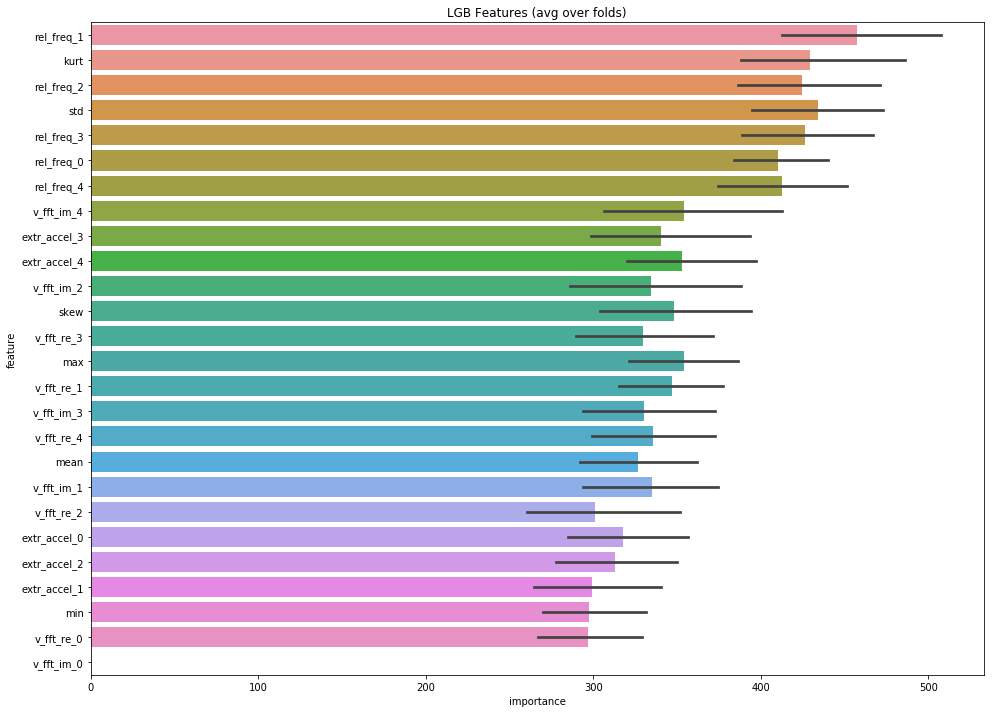

In [102]:
%%time
params = {'num_leaves': 128,
          'min_data_in_leaf': 79,
          'objective': 'gamma',
          'max_depth': 6,
          'learning_rate': 0.01,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8126672064208567,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501,
          'feature_fraction': 0.2,
          'n_estimators': 4000
         }
oof_lgb, prediction_lgb, feature_importance, lgb_model = train_model(
    train_X[train_X.columns.drop(lgb_filtered_columns)],
    test_X[test_X.columns.drop(lgb_filtered_columns)],    
    train_y,
    params=params,
    model_type='lgb',
    plot_feature_importance=True
)

# Neural Network

In [103]:
patience = 50
call_ES = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=patience,
    verbose=1,
    mode='auto',
    baseline=None,
    #restore_best_weights=True
)

In [104]:
#%%time
cb = [ModelCheckpoint("model.hdf5", save_best_only=True, period=3)]
def create_model(input_dim=10):

    # The LSTM architecture
    model = Sequential()
    # First LSTM layer with Dropout regularisation
    model.add(CuDNNLSTM(units=50, return_sequences=True, input_shape=(None, input_dim)))
    model.add(Dropout(0.2))
    # Second LSTM layer
    model.add(CuDNNLSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    # Third LSTM layer
    model.add(CuDNNLSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    # Fourth LSTM layer
    model.add(CuDNNLSTM(units=50))
    model.add(Dropout(0.2))
    # The output layer
    model.add(Dense(units=1))

    # Compiling the RNN


    model.summary()
    model.compile(optimizer='rmsprop', loss='mae')
    return model

In [105]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

nn_oof = np.zeros(len(train_X))
train_score = []
fold_idxs = []

#def train_nn(train_X, test_X, train_columns):
def train_nn(train_X, test_X, train_y):
    nn_predictions = np.zeros(len(test_X))
    num_of_features = train_X.shape[-1]
    model = None
    #print(train_X.shape)
    #print(train_y.shape)
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_X, train_y)):
        strLog = "fold {}".format(fold_)
        print(strLog)
        fold_idxs.append(val_idx)
    
        #X_tr, X_val = train_X[train_columns].iloc[trn_idx], train_X[train_columns].iloc[val_idx]
        X_tr, X_val = train_X[trn_idx], train_X[val_idx]
        #X_tr = (X_tr.values).reshape(len(X_tr), 1, num_of_features)
        X_tr = X_tr.reshape(len(X_tr), 1, num_of_features)
        #print("X_tr:\n", X_tr[2, :])
        #X_val = (X_val.values).reshape(len(X_val), 1, num_of_features)
        X_val = X_val.reshape(len(X_val), 1, num_of_features)
        #print("X_val:\n", X_val[2, :])
        y_tr, y_val = train_y[trn_idx], train_y[val_idx]
        #print("y_tr:\n", y_tr[2])
        #print("y_val:\n", y_val[2])
        model = create_model(num_of_features)
        model.fit(X_tr, y_tr, epochs=50, batch_size=32, verbose=2, callbacks=[call_ES,], validation_data=[X_val, y_val]) #
    
        nn_oof[val_idx] = model.predict(X_val)[:,0]
    
        #NN_predictions += model.predict(test_X[train_columns])[:,0] / folds.n_splits
        #test_X = (test_X.values).reshape(len(test_X), 1, num_of_features)
        test_X = test_X.reshape(len(test_X), 1, num_of_features)
        nn_predictions += model.predict(test_X)[:,0] / folds.n_splits
        history = model.history.history
        tr_loss = history["loss"]
        val_loss = history["val_loss"]
        print(f"loss: {tr_loss[-patience]:.3f} | val_loss: {val_loss[-patience]:.3f} | diff: {val_loss[-patience]-tr_loss[-patience]:.3f}")
        train_score.append(tr_loss[-patience])
        #     break
    
        cv_score = mean_absolute_error(train_y, nn_oof)
        print(f"After {n_fold} test_CV = {cv_score:.3f} | train_CV = {np.mean(train_score):.3f} | {cv_score-np.mean(train_score):.3f}", end=" ")
    return model, nn_predictions

In [106]:
%%time
'''
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

NN_oof = np.zeros(len(train_X))
train_score = []
fold_idxs = []

NN_predictions = np.zeros(len(test_X))

num_of_features = train_X.shape[-1]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_X.values, train_y.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    fold_idxs.append(val_idx)
    
    ## X_tr, X_val = train_X[train_columns].iloc[trn_idx], train_X[train_columns].iloc[val_idx]
    X_tr, X_val = train_X[trn_idx], train_X[val_idx]
    X_tr = X_tr.reshape(len(X_tr), 1, num_of_features)
    X_val = X_val.reshape(len(X_val), 1, num_of_features)
    y_tr, y_val = train_y[trn_idx], train_y[val_idx]
    model = create_model(num_of_features)
    model.fit(X_tr, y_tr, epochs=50, batch_size=32, verbose=2, callbacks=[call_ES,], validation_data=[X_val, y_val]) #
    
    NN_oof[val_idx] = model.predict(X_val)[:,0]
    
    #NN_predictions += model.predict(test_X[train_columns])[:,0] / folds.n_splits
    test_X = (test_X.values).reshape(len(test_X), 1, num_of_features)
    NN_predictions += model.predict(test_X)[:,0] / folds.n_splits
    history = model.history.history
    tr_loss = history["loss"]
    val_loss = history["val_loss"]
    print(f"loss: {tr_loss[-patience]:.3f} | val_loss: {val_loss[-patience]:.3f} | diff: {val_loss[-patience]-tr_loss[-patience]:.3f}")
    train_score.append(tr_loss[-patience])
#     break
    
cv_score = mean_absolute_error(train_y, NN_oof)
print(f"After {n_fold} test_CV = {cv_score:.3f} | train_CV = {np.mean(train_score):.3f} | {cv_score-np.mean(train_score):.3f}", end=" ")
'''

nn_filtered_columns = ['extr_mean_%i' % i for i in range(5)] + ['extr_std_%i' % i for i in range(5)]
nn_filtered_columns_np = select_columns(X, nn_filtered_columns)

#nn_model = train_nn(train_X, test_X, train_X.columns.drop(nn_filtered_columns))
nn_model, nn_predictions = train_nn(
    (train_X.values)[:, nn_filtered_columns_np],
    (test_X.values)[:, nn_filtered_columns_np],
    train_y.values
)


fold 0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_21 (CuDNNLSTM)    (None, None, 50)          15600     
_________________________________________________________________
dropout_21 (Dropout)         (None, None, 50)          0         
_________________________________________________________________
cu_dnnlstm_22 (CuDNNLSTM)    (None, None, 50)          20400     
_________________________________________________________________
dropout_22 (Dropout)         (None, None, 50)          0         
_________________________________________________________________
cu_dnnlstm_23 (CuDNNLSTM)    (None, None, 50)          20400     
_________________________________________________________________
dropout_23 (Dropout)         (None, None, 50)          0         
_________________________________________________________________
cu_dnnlstm_24 (CuDNNLSTM)    (None, 50)                20400     
___

Epoch 47/50
 - 5s - loss: 2.1854 - val_loss: 2.2590
Epoch 48/50
 - 5s - loss: 2.1730 - val_loss: 2.2804
Epoch 49/50
 - 5s - loss: 2.1710 - val_loss: 2.2941
Epoch 50/50
 - 5s - loss: 2.1806 - val_loss: 2.2672
loss: 2.767 | val_loss: 2.325 | diff: -0.442
After 5 test_CV = 4.296 | train_CV = 2.749 | 1.547 fold 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_29 (CuDNNLSTM)    (None, None, 50)          15600     
_________________________________________________________________
dropout_29 (Dropout)         (None, None, 50)          0         
_________________________________________________________________
cu_dnnlstm_30 (CuDNNLSTM)    (None, None, 50)          20400     
_________________________________________________________________
dropout_30 (Dropout)         (None, None, 50)          0         
_________________________________________________________________
cu_dnnlstm_31 (CuDNNLSTM)    

Epoch 41/50
 - 5s - loss: 2.2085 - val_loss: 2.2360
Epoch 42/50
 - 5s - loss: 2.2036 - val_loss: 2.2624
Epoch 43/50
 - 5s - loss: 2.1957 - val_loss: 2.2303
Epoch 44/50
 - 5s - loss: 2.1940 - val_loss: 2.2290
Epoch 45/50
 - 5s - loss: 2.1956 - val_loss: 2.2345
Epoch 46/50
 - 5s - loss: 2.1927 - val_loss: 2.2301
Epoch 47/50
 - 5s - loss: 2.1970 - val_loss: 2.2318
Epoch 48/50
 - 5s - loss: 2.1869 - val_loss: 2.2431
Epoch 49/50
 - 5s - loss: 2.1923 - val_loss: 2.2515
Epoch 50/50
 - 5s - loss: 2.1848 - val_loss: 2.2393
loss: 2.799 | val_loss: 2.309 | diff: -0.491
After 5 test_CV = 2.946 | train_CV = 2.761 | 0.185 fold 4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_37 (CuDNNLSTM)    (None, None, 50)          15600     
_________________________________________________________________
dropout_37 (Dropout)         (None, None, 50)          0         
_______________________________________________

In [107]:
xgb_holdout_pred = xgb_model.predict(xgb.DMatrix(holdout_X[holdout_X.columns.drop(xgb_filtered_columns)].values, feature_names=holdout_X.columns.drop(xgb_filtered_columns)), ntree_limit=xgb_model.best_ntree_limit)
#print(xgb_holdout_pred.shape)
lgb_holdout_pred = lgb_model.predict(holdout_X[holdout_X.columns.drop(lgb_filtered_columns)].values)
#print(lgb_holdout_pred.shape)
nn_holdout_pred = nn_model.predict(
    (holdout_X[holdout_X.columns.drop(nn_filtered_columns)].values).reshape(len(holdout_X), 1, holdout_X[holdout_X.columns.drop(nn_filtered_columns)].shape[-1])).reshape((holdout_X.shape[0]))
#print(nn_holdout_pred.shape)
print("xgb holdout prediction MAE:", mean_absolute_error(holdout_y, xgb_holdout_pred))
print("lgb holdout prediction MAE:", mean_absolute_error(holdout_y, lgb_holdout_pred))
print("nn holdout prediction MAE:", mean_absolute_error(holdout_y, nn_holdout_pred))

xgb holdout prediction MAE: 2.3039736297203293
lgb holdout prediction MAE: 2.3020243544862184
nn holdout prediction MAE: 2.3046972576230735


In [108]:
#holdout_y.shape

In [109]:
holdout_prediction = (xgb_holdout_pred + lgb_holdout_pred + nn_holdout_pred) / 3
#print(holdout_prediction.shape)
print("total holdout prediction MAE:", mean_absolute_error(holdout_y, holdout_prediction))

total holdout prediction MAE: 2.28126752970671


In [110]:
today = str(datetime.date.today())
submission = pd.read_csv('../input/sample_submission.csv')

submission["time_to_failure"] = (prediction_xgb + prediction_lgb + nn_predictions) / 3
submission.to_csv(f'xgb_lgb_nn_{i}_{today}_submission.csv', index=False)
submission.head()

,seg_id,time_to_failure
0,seg_00030f,2.042217
1,seg_0012b5,6.224799
2,seg_00184e,7.604082
3,seg_003339,9.050979
4,seg_0042cc,6.931810
